In [1]:
# fundamentals
import os, glob
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import scipy.stats as stats
import funcs as funcs
import datetime
import imp

# plotting libraries and setup
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('font', size=12)
plt.rc('facecolor', )

# met mast functions and utilities
import met_funcs as MET
import vis as vis
import utils as utils

In [6]:
# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/)
towerID = 'M5'
metPathLoHz = '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/{}/txt/'.format(towerID)
figPath = '../../figs/{}'.format(towerID)

In [7]:
# time range
years  = [ int(a) for a in np.arange(2012,2018,1) ] #
months = [ int(a) for a in np.arange(1,12.1,1) ]
# or just get all?

In [8]:
inputfiles = [] # list of files to be read into metdata object
filecount = 0

for year in years:
    for month in months:
        fName = glob.glob(os.path.join(metPathLoHz,'{0}_{1}.txt'.format(year,month_name[month])))        
        if len(fName)>0:
            fName = fName[0] 
            inputfiles.append(fName)
print('{} files to be read into MetData'.format(len(inputfiles)))


64 files to be read into MetData


In [9]:
## load data from list of input data files
metdat = MET.load_met_data(inputfiles, verbose=False)

## remove columns that are all nans
MET.drop_nan_cols(metdat)

## use qc columns to mask data (qc != 1 --> questionable data)
metdat = MET.qc_mask(metdat)

## flag data by stability class
stabconds, stabcat = MET.flag_stability(metdat)

## group columns based on category, assign units, labels, savenames
varcats, varunits, varlabels, varsave = MET.categorize_fields(metdat, keeplist=True)

## drop columns not in any of the categories, filter TI, temperature, stability parameters
MET.groom_data(metdat, varcats)

filtcols = [col for col in metdat.columns if 'air' not in col.lower() and 'humidity' not in col.lower()]
## Finally, reject outliers more than 5 standard deviations from the mean
for col in metdat.columns:
    try:
        metdat[col] = MET.reject_outliers(metdat[col], m=6)
    except:
        continue

number of data columns: 461
number of QC columns: 471
number of columns after filtering: 142


In [12]:
catinfo = {}
catinfo['columns'] = varcats
catinfo['units'] = varunits
catinfo['labels'] = varlabels
catinfo['save'] = varsave

In [13]:
# M5 excluded angles,
# Obstruction,	start ang.	end ang.
# GE			46		146
# Alstom		123		203
# CART-3		172		213
# CART-2		177		212
# Siemens		165		210
# Gamesa		189		228
exclude_angles = [(46,146),(123,203),(172,213),(177,212),(165,210),(189,228)]

In [14]:
categories = list(catinfo['columns'].keys())

for cat in categories:
    if 'stability flag' in cat.lower():
        continue
    
    # savepath for new figs
    savecat = catinfo['save'][cat]
    catfigpath = os.makedirs(os.path.join(figPath,savecat), mode=0o777, exist_ok=True)
    catfigpath = os.path.join(figPath,savecat)
    
    # Profiles
    ## cumulative profile
    fig, ax = vis.cumulative_profile(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly profile
    fig, ax = vis.monthly_profile(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile_monthly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## stability profile
    fig,ax = vis.stability_profile(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile_stability.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly stability profile
    fig,ax = vis.monthly_stability_profiles(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_profile_monthly_stability.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    # Diurnal cycle
    ## cumulative hourly plot
    fig,ax = vis.hourlyplot(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_hourly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly hourly plot
    fig,ax = vis.monthlyhourlyplot(metdat, catinfo, cat)
    fig.savefig(os.path.join(catfigpath,'{}_{}_hourly_monthly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')

    plt.close('all')
    
    

## Figures by height
Each of the following figures could be drawn for any probe height. Currently, figures are only drawn for z=80m (hub height)

In [94]:
categories = list(catinfo['columns'].keys())

for cat in categories:
    if 'stability flag' in cat.lower():
        continue
    
    # savepath for new figs
    savecat = catinfo['save'][cat]
    catfigpath = os.path.join(figPath,savecat)
    
    catcolumns, probe_heights, _ = utils.get_vertical_locations(catinfo['columns'][cat])
    
    ## wind roses by height
    for height in [87]:#probe_heights:
    
        # SCATTER PLOTS
        ## cumulative scatter
        fig, ax = vis.winddir_scatter(metdat, catinfo, cat, vertloc=height, exclude_angles=exclude_angles)
        fig.savefig(os.path.join(catfigpath,'{}_{}_scatter_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # stability scatter
        fig, ax = vis.stability_winddir_scatter(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_scatter_stability_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # HISTOGRAMS
        # cumulative
        fig,ax = vis.hist(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_hist_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # stability breakout
        fig,ax = vis.hist_by_stability(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_hist_stabilty_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

        # stability stacked
        fig,ax = fig,ax = vis.stacked_hist_by_stability(metdat, catinfo, cat, vertloc=height)
        fig.savefig(os.path.join(catfigpath,'{}_{}_hist_stabilty_stacked_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')
        
        if 'ti' not in cat.lower():
            # groupby direction scatter
            fig,ax = vis.groupby_scatter(metdat, catinfo, cat, vertloc=height, abscissa='direction', groupby='ti')
            fig.set_size_inches(8,3)
            fig.tight_layout()
            fig.savefig(os.path.join(catfigpath,'{}_{}_TI_scatter_{}m.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/nhamilto/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:1060: RuntimeWarning: invalid value encountered in greater_equal
  if (values >= 0).all():
/Users/nhamilto/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:1062: RuntimeWarning: invalid value encountered in less_equal
  elif (values <= 0).all():


## Wind roses
Might as well draw all of the wind roses (by height)

In [12]:
# wind roses
cat = 'speed'
catcolumns, probe_heights, ind = utils.get_vertical_locations(catinfo['columns'][cat])
# savepath for new figs
savecat = catinfo['save'][cat]
catfigpath = os.makedirs(os.path.join(figPath,savecat,'roses'), mode=0o777, exist_ok=True)
catfigpath = os.path.join(figPath,savecat,'roses')
## wind roses by height
for height in probe_heights:
    ## cumulative wind rose
    fig,ax,leg = vis.rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,15,6), ylim=9)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')
    ## monthly wind roses
    fig,ax,leg = vis.monthly_rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,15,6), ylim=12)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_monthly_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/nhamilto/anaconda/lib/python3.6/site-packages/windrose/windrose.py:592: RuntimeWarning: invalid value encountered in true_divide
  table = table * 100 / table.sum()
/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


In [13]:
# TI roses
cat = 'ti'
catcolumns, probe_heights, ind = utils.get_vertical_locations(catinfo['columns'][cat])
# savepath for new figs
savecat = catinfo['save'][cat]
catfigpath = os.makedirs(os.path.join(figPath,savecat,'roses'), mode=0o777, exist_ok=True)
catfigpath = os.path.join(figPath,savecat,'roses')
## wind roses by height
for height in probe_heights:
    ## cumulative wind rose
    fig,ax,leg = vis.rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,40,6), ylim=12)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')
    ## monthly wind roses
    fig,ax,leg = vis.monthly_rose_fig(metdat, catinfo, cat, vertloc=height, bins=np.linspace(0,40,6), ylim=14)
    fig.savefig(os.path.join(catfigpath,'{}_{}_rose_monthly_{}m.png'.format(towerID, cat, height)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/nhamilto/anaconda/lib/python3.6/site-packages/windrose/windrose.py:592: RuntimeWarning: invalid value encountered in true_divide
  table = table * 100 / table.sum()
/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


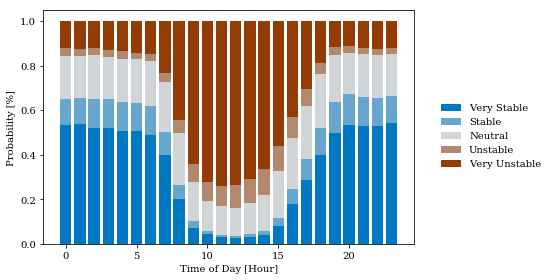

In [14]:
fig, ax = vis.normalized_hist_by_stability(metdat, catinfo)
fig.savefig(os.path.join(figPath,'{}_normalized_stability_flag.png'.format(towerID)), dpi=200, bbox_inches='tight')

/Volumes/Sitechar/coderepo/nicholas/vis.py:847: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdat = temp.loc[ii+1,cond]


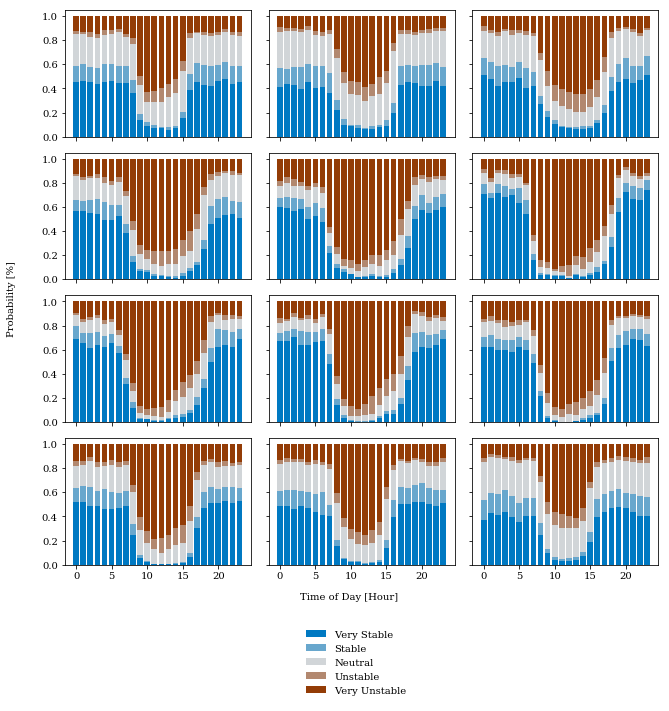

In [15]:
fig, ax = vis.normalized_monthly_hist_by_stability(metdat,catinfo)
fig.savefig(os.path.join(figPath,'{}_normalized_stability_flag_monthly.png'.format(towerID)), dpi=200, bbox_inches='tight')

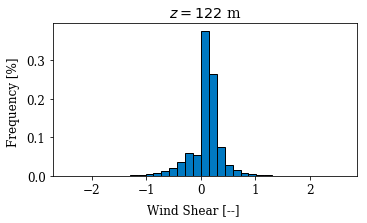

In [61]:
cat = 'wind shear'
# savepath for new figs
savecat = catinfo['save'][cat]
catfigpath = os.path.join(figPath,savecat)
fig,ax = vis.hist(metdat, catinfo, cat, vertloc=122)
fig.savefig(os.path.join(catfigpath,'{}_{}_hist_{}.png'.format(towerID, savecat, 122)), dpi=200, bbox_inches='tight')

In [57]:
height

122

In [53]:
plt.rcParams.update({'font.size': 12})

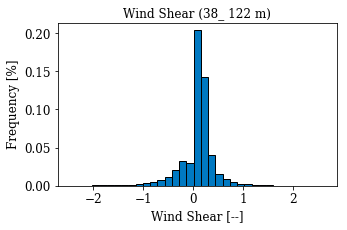

In [73]:
colors = utils.get_nrelcolors()
blue = colors['blue'][0]
cat = 'wind shear'
# savepath for new figs
savecat = catinfo['save'][cat]
catfigpath = os.path.join(figPath,savecat)
catcolumns, probe_heights, ind = utils.get_vertical_locations(catinfo['columns'][cat])
for col in catcolumns[5:6]:
    fig, ax = plt.subplots(figsize=(5,3))
    metdat[col].hist(ax=ax, bins=35, color=blue, edgecolor='k', density=False, weights = np.ones(metdat[col].count())/len(metdat[col]))
    ax.grid(False)
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Frequency [%]', fontsize=12)
    ax.set_xlabel(catinfo['labels'][cat], fontsize=12)
fig.savefig(os.path.join(catfigpath,'{}_{}_hist_{}.png'.format(towerID, savecat, 122)), dpi=200, bbox_inches='tight')

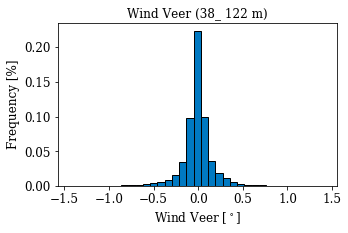

In [76]:
colors = utils.get_nrelcolors()
blue = colors['blue'][0]
cat = 'wind veer'
# savepath for new figs
savecat = catinfo['save'][cat]
catfigpath = os.path.join(figPath,savecat)
catcolumns, probe_heights, ind = utils.get_vertical_locations(catinfo['columns'][cat])
for col in catcolumns[5:6]:
    fig, ax = plt.subplots(figsize=(5,3))
    metdat[col].hist(ax=ax, bins=35, color=blue, edgecolor='k', density=False, weights = np.ones(metdat[col].count())/len(metdat[col]))
    ax.grid(False)
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Frequency [%]', fontsize=12)
    ax.set_xlabel(catinfo['labels'][cat], fontsize=12)
fig.savefig(os.path.join(catfigpath,'{}_{}_hist_{}.png'.format(towerID, savecat, 122)), dpi=200, bbox_inches='tight')

In [129]:
imp.reload(vis)

<module 'vis' from '/Volumes/Sitechar/coderepo/nicholas/vis.py'>

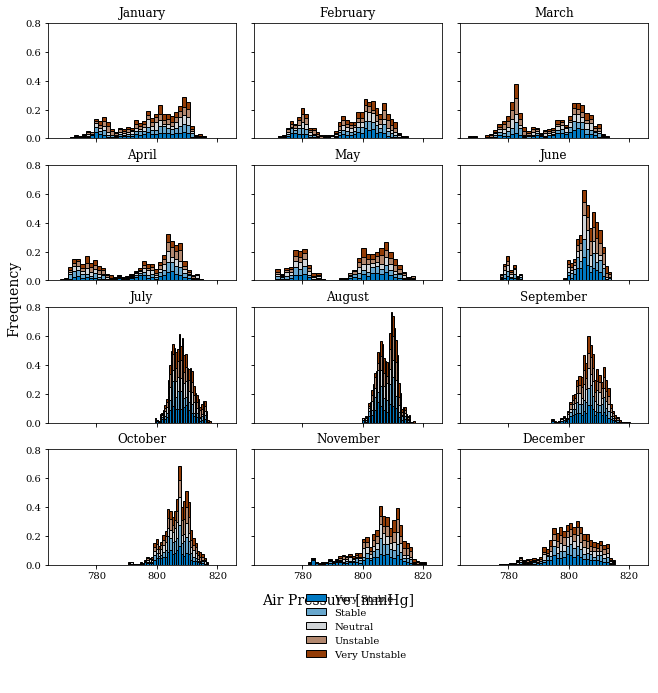

In [14]:
for cat in ['air pressure']:#categories:
    savecat = catinfo['save'][cat]
    catfigpath = os.path.join(figPath,savecat)
    fig,ax = vis.monthly_stacked_hist_by_stability(metdat,catinfo,cat, vertloc=87)
    fig.savefig(os.path.join(catfigpath,'{}_{}_monthly_stacked_hist_by_stability_{}.png'.format(towerID, savecat, 87)), dpi=200, bbox_inches='tight')

In [30]:
# direction conditioned
dircol, probe_heights, ind = utils.get_vertical_locations(catinfo['columns']['direction'], location=87)
spdcol, probe_heights, ind = utils.get_vertical_locations(catinfo['columns']['speed'], location=87)

northerly = metdat[(metdat[dircol] < 45) | (metdat[dircol] > 315)]

southerly = metdat[(metdat[dircol] > 135) & (metdat[dircol] < 225)]

weakwest = metdat[(metdat[dircol] > 225) & (metdat[dircol] < 315) & (metdat[spdcol] < 10)]

strongwest = metdat[(metdat[dircol] > 225) & (metdat[dircol] < 315) & (metdat[spdcol] > 10)]


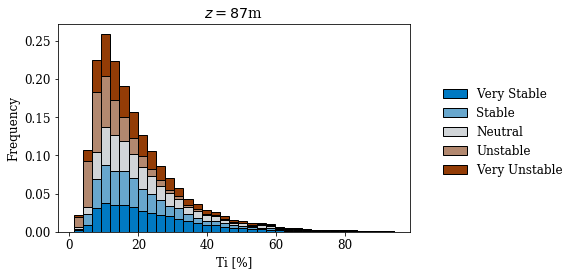

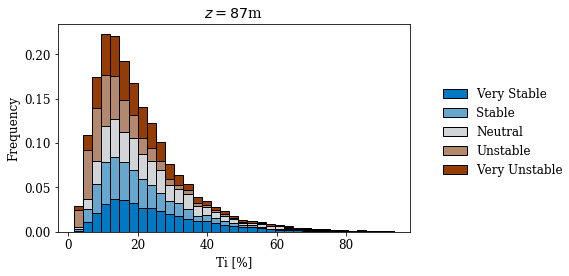

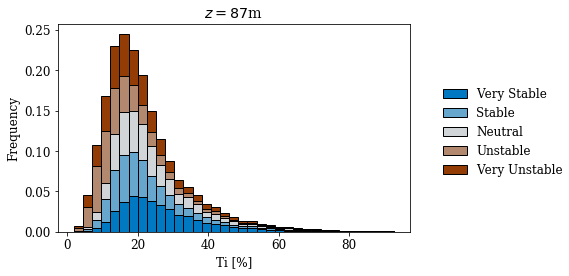

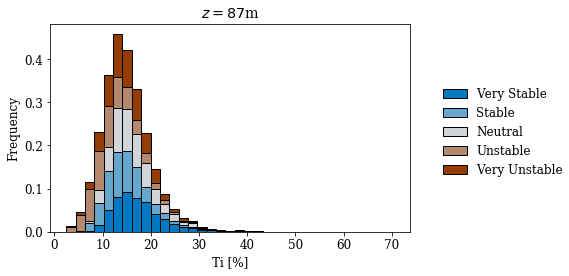

In [31]:
imp.reload(vis)
cat = 'ti'
fig,ax = vis.stacked_hist_by_stability(northerly, catinfo, cat, vertloc=87)
fig,ax = vis.stacked_hist_by_stability(southerly, catinfo, cat, vertloc=87)
fig,ax = vis.stacked_hist_by_stability(weakwest, catinfo, cat, vertloc=87)
fig,ax = vis.stacked_hist_by_stability(strongwest, catinfo, cat, vertloc=87)

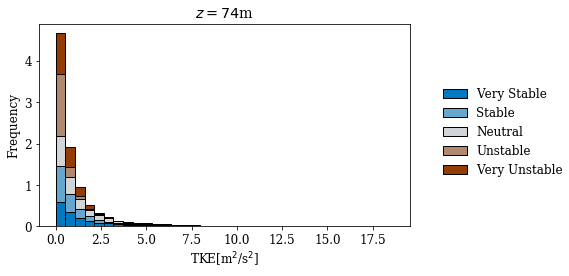

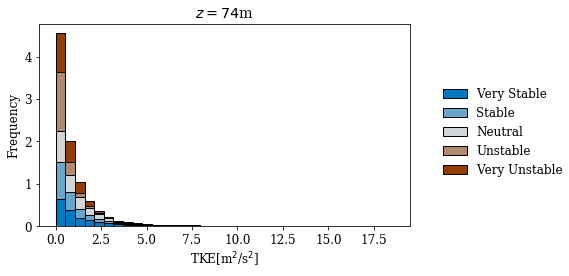

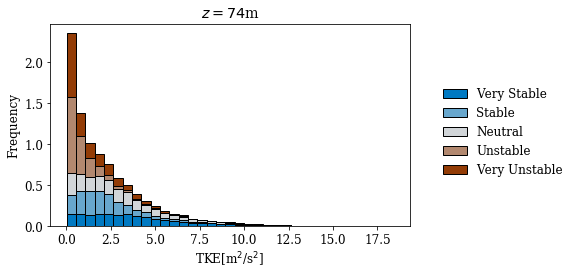

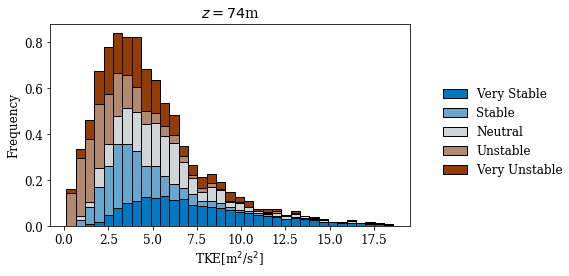

In [36]:
cat = 'turbulent kinetic energy'
fig,ax = vis.stacked_hist_by_stability(northerly, catinfo, cat, vertloc=87)
fig,ax = vis.stacked_hist_by_stability(southerly, catinfo, cat, vertloc=87)
fig,ax = vis.stacked_hist_by_stability(weakwest, catinfo, cat, vertloc=87)
fig,ax = vis.stacked_hist_by_stability(strongwest, catinfo, cat, vertloc=87)

## Monthly histograms 

In [91]:
categories = list(catinfo['columns'].keys())
imp.reload(vis)
for cat in categories:
    
    height = 87
    if 'shear' in cat.lower(): 
        height = 122
    if 'stability flag' in cat.lower():
        continue
        
    savecat = catinfo['save'][cat]
    catfigpath = os.path.join(figPath,savecat)
    
    fig,ax = vis.monthly_hist(metdat, catinfo, cat, vertloc=height)
    fig.savefig(os.path.join(catfigpath,'{}_{}_monthly_hist_{}.png'.format(towerID, savecat, height)), dpi=200, bbox_inches='tight')
    
    plt.clf()

In [93]:
metdat.columns

Index(['Speed (cup_ 130 m)', 'Ti (cup_ 130 m)', 'Direction (Vane_ 130 m)',
       'Speed (cup_ 122 m)', 'Ti (cup_ 122 m)', 'Direction (Vane_ 122 m)',
       'Speed (cup_ 105 m)', 'Ti (cup_ 105 m)', 'Direction (Vane_ 105 m)',
       'Speed (cup_ 87 m)',
       ...
       'Coherent TKE (15m)', 'Dissipation rate (Direct_ 15m)',
       'Monin-Obukhov Length (15m)', 'Stability parameter z/L (15m)',
       'Stability Flag (119m)', 'Stability Flag (100m)',
       'Stability Flag (74m)', 'Stability Flag (61m)', 'Stability Flag (41m)',
       'Stability Flag (15m)'],
      dtype='object', length=142)